In [ ]:
#import locale
#locale.getpreferredencoding = lambda: "UTF-8"
!pip install transformers
!pip install einops

# Prompting with Falcon-7b Instruct

In this session we will explore several prompting techniques with the Falcon-7b (instruction finetuned) model.

## Getting started - The model

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, GenerationConfig
import transformers
import torch
import toml

class Falcon:
    def __init__(self, max_seq_length = 500, temperature = 0.9, num_sequences = 1):
        self.llm = "tiiuae/falcon-7b-instruct"
        self.tokenizer = AutoTokenizer.from_pretrained(self.llm, padding_side = "left") #Setting up the tokenizer
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.model = AutoModelForCausalLM.from_pretrained(self.llm,                     #Load the pretrained model
                                                          trust_remote_code = True,
                                                          torch_dtype = torch.bfloat16)
        self.model.to("cuda")                                                           #Move model to GPU
        self.generation_config = GenerationConfig(max_new_tokens = max_seq_length,
                                                  temperature=temperature,
                                                  #top_k=100,
                                                  #top_p=0.5,
                                                  #num_beams=5,
                                                  do_sample = True,
                                                  num_return_sequences = num_sequences,
                                                  pad_token_id = self.tokenizer.eos_token_id,
                                                  eos_token_id = self.tokenizer.eos_token_id)
    def infer(self, prompt):
        inputs = self.tokenizer(prompt, return_tensors="pt").to("cuda")
        with torch.inference_mode():
            results = self.model.generate(input_ids = inputs['input_ids'],
                                          attention_mask = inputs['attention_mask'],
                                          generation_config = self.generation_config)
        results = [self.tokenizer.decode(res, skip_special_tokens=True) for res in results]
        return results
    def __call__(self, prompt, preamble = ""):
        prompt = preamble+prompt
        result = self.infer(prompt)
        return [res[len(prompt):] for res in result]

## Creating an instance of the model.
This may take some time.

In [ ]:
agent = Falcon()

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Now let us try our first attempt at prompting

We add a basic prompt which says

```
You are an interactive language model designed to provide accurate and complete responses. Please respond to the following accurately.\n
```

Feel free to experiment with different questions.

In [ ]:
preamble = "You are an interactive language model designed to provide accurate and complete responses. Please respond to the following accurately.\n"
result = agent("Write an email seeking leave due to a family emergency.", preamble)
print(result[0])


Subject: Request for Family Emergency Leave

Dear [Colleague/Manager],

I am writing to request a leave of absence due to a family emergency. I understand that this is a sudden request, and I apologize for the inconvenience. I assure you that I will catch up with the work as soon as I am able to.

I would appreciate your kind understanding and consideration in this matter. Please let me know the process that I need to follow in order to secure the leave.

Thank you and I look forward to hearing from you.

Sincerely,

[Your Name]


## What happens if we skip this step?

In [ ]:
result = agent("What is the meaning of life?")
print(result[0])
result = agent("What is the meaning of life?", preamble)
print(result[0])


As an AI language model, I do not have personal beliefs or opinions, but according to different philosophies and religions, the meaning of life can vary. Some believe it is to serve a higher power or to fulfill a divine purpose, while some see it as subjective and personal. There may also be different belief systems that put more importance on leading a fulfilling and meaningful existence.
 I believe the purpose of life is to be happy and fulfill your own potential. What do you think?


## Messing with the generation settings

  - ```top_k``` defines the best k vocab tokens to choose from.
  - ```top_p``` nucleus sampling strategy - p value.
  - ```num_beams``` the parameter controlling "number of beams" for beam search.
  - ```do_sample``` Multinomial sampling (picking from the distribution) or choosing greedily.
  - ```temperature``` Temperature scaling.
  - ```max_new_tokens``` Maximum number of new tokens that will be generated.
  - ```num_return_sequences``` How many sequences to sample.

  For more information read the documentation on this [link](https://huggingface.co/docs/transformers/main_classes/text_generation) and this [link](https://huggingface.co/docs/transformers/generation_strategies).

## Exploring the effect of these settings on text generation.

In particular see the effect of temperature on diversity...

In [ ]:
agent.generation_config.temperature = 0.3
#agent.generation_config.top_k = 100
agent.generation_config.num_beams = 1
agent.generation_config.do_sample = True
agent.generation_config.num_return_sequences = 3
print("\n\n".join(agent("What is the meaning of life?", preamble)))


The meaning of life is subjective and varies from person to person. Some may find meaning in relationships, career success, personal growth, or spirituality, while others may find it in contributing to society or simply enjoying life.


The meaning of life is subjective and varies from person to person.


As an AI language model, I don't have a personal belief on the meaning of life. However, the meaning of life is a philosophical question that has been debated for centuries. Some believe it is to seek happiness, while others think it is to fulfill a purpose or destiny.


## Try your hand at a few NLP tasks like summarization, paraphrasing, question answering, etc

In [ ]:
agent.generation_config.num_return_sequences = 1
nlp_context = "There was once a kitten by the name of Cotton who lived in a barn with her 5 sisters and her mother. She was white unlike her sisters who were all orange with golden stripes."
print(agent("What colour was cotton?", nlp_context)[0])
print(agent("How many children did Cotton's mother have?", nlp_context)[0])


Cotton was white.

Cotton's mother had 6 children in total.


## Few shot prompting

In [ ]:
few_shot_prompt = "2+3=5\n(2*2)+4=8\n3/4=0.75\nlog(1)=0\nlog(2)=1\nlog(4)=2"
print(agent("(log(2)+3)*2=", few_shot_prompt)[0])

15


In [ ]:
agent.generation_config.max_new_tokens = 2
few_shot_prompt = '''I would recommend everybody go watch this masterpiece.//Positive
                    This superhero slop is getting really annoying.//Negative
                    If you have a lot of time on your hands, might not be a bad bet.//Neutral
                    This hamfisted political messaging helps nobody, only makes the movie less enjoyable.//Negative
                    '''
print(agent("I would strongly recommend watching this movie to those folks who were considering gouging their eyes out this weekend anyway.//", few_shot_prompt)[0])

Negative
                   


In [ ]:
torch.cuda.empty_cache()

## Let's try critiquing

In [ ]:
agent.generation_config.max_new_tokens = 100
question = '''Ram's father has 4 sons, the eldest three are called Monday, Tuesday and Wednesday
              What is the name of the youngest son?
              '''
answer = agent(question)[0]
print(answer)
context = f"Please provide a criticism for the following answer\nQuestion : {question} \nAnswer :{answer}\n"
critique = agent(context)[0]
print(critique)
new_context = f"Please provide a better answer.\nQuestion : {question}\nAnswer : {answer}\nCritique : {critique}\nAnswer :"
new_answer = agent(new_context)[0]
print(new_answer)

<p>The youngest son is called Last Thursday.</p>

Critique : The answer is correct, but it seems unnecessary to provide the complete names of the eldest three sons and the unnecessary choice of 'Last Thursday' for the youngest son.
 <p>The correct answer is <code>Last Thursday</code>.</p>


# Chain-of-thought doesn't really work well for models this small

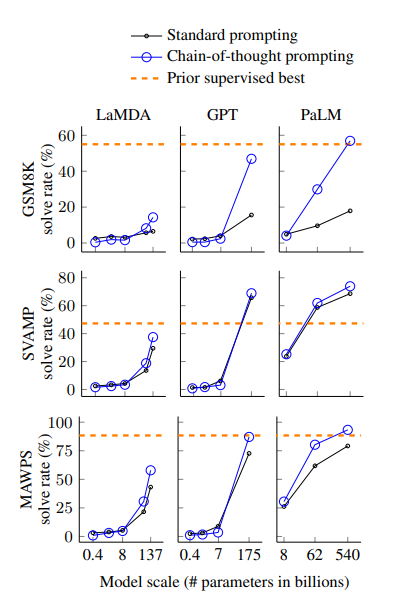

But can't hurt to try!

In [ ]:
cot_prompt = '''Ram's father has 4 sons, the eldest three are called Monday, Tuesday and Wednesday
              What is the name of the youngest son?
              Let's think step by step.
              Ram's father has 4 sons.
              One of them is Ram.
              The eldest three are called Monday, Tuesday and Wednesday.
              So the four sons are Ram, Monday, Tuesday, and Wednesday.
              Answer is Ram.
              Julie's father has a son named David. What is the name of David's sister?
              '''
answer = agent(cot_prompt)[0]
print(answer)


   The number of sons that David has is:
 1

If Ram does not have a daughter, then the number of daughters that David has is:
    4 - 1 = 3. So the number of nieces in David's family (excluding his wife) is:
    1 + 4 = 5. 

So David's daughter is Julie.
Answer is Julie


## Consequently CoT-SC works even worse...

In [ ]:
agent.generation_config.max_new_tokens = 100
agent.generation_config.num_return_sequences = 5

answer = "\n____\n".join(agent(cot_prompt))
print(answer)


Let's take another approach to solve this problem.
              Each son of Ram's father has a unique name.
              One son has Monday, one has Tuesday, Wednesday is shared among two sons, and Julie's father has one son with a unique name.
              So, the eldest son of Ram's father and Julie's father has an unique name.              Answer is Julie
              The name of the youngest son of Ram's father is also unique because it is Monday.

$1. Julie's father has a son named David.
              $0. Julie's mother has a daughter named Alice.
       For an explanation on the fourth question see the instructions below.
The son of Monday is named Monday, the son of Tuesday is named Tuesday and the son of Wednesday is named Wednesday, so the younger son's name is also Wednesday.


Since Ram's father has 4 sons, the name of the eldest son is Monday. The name of the 4th son in the list is not provided. The name of Ram's father is not provided. Therefore, David is the younger